In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
#SAMPLE DATA IN CSVs
#Date	Price	Open	High	Low	Vol.	Change %
#4/25/25	86.34	84.3	87.23	82.97	807.63K	2.42%
#4/24/25	84.3	83.29	84.57	80.82	788.18K	1.21%
#4/23/25	83.29	83.47	85.19	82.28	1.12M	-0.22%
#4/22/25	83.47	78.13	84.68	77.48	974.17K	6.83%
#4/21/25	78.14	77.78	81.55	77.45	842.50K	0.45%
#4/20/25	77.78	76.08	78.43	75.45	427.79K	2.24%
#4/19/25	76.08	76	76.73	74.48	424.90K	0.10%
#4/18/25	76	74.94	77.05	74.63	451.81K	1.41%
#4/17/25	74.94	74.34	76.48	73.69	605.86K	0.83%

In [4]:
#USEFUL FUNCTIONS

def clean_volume(vol):
    if isinstance(vol, str):
        vol = vol.replace(',', '')
        if 'K' in vol:
            return float(vol.replace('K', '')) * 1_000
        elif 'M' in vol:
            return float(vol.replace('M', '')) * 1_000_000
        elif 'B' in vol:
             return float(vol.replace('B', '')) * 1_000_000_000
        else:
            return float(vol)
    return vol

def load_and_clean(filepath):
    df = pd.read_csv(filepath, thousands=',', quotechar='"')
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])

    # Drop columns containing '%'
    cols_to_drop = [col for col in df.columns if '%' in col]
    df = df.drop(columns=cols_to_drop)

    # Clean 'Vol.' column
    if 'Vol.' in df.columns:
        df['Vol.'] = df['Vol.'].apply(clean_volume)

    # Convert all columns except 'Date' to numeric
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows where 'Price' is missing
    df = df.dropna(subset=['Price'])

    # Sort oldest to newest
    df = df.sort_values('Date').reset_index(drop=True)

    # Calculate manual returns
    df['Price_Return'] = df['Price'].pct_change(fill_method=None)

    return df

def load_and_clean_monthly(filepath):
    df = pd.read_csv(filepath, thousands=',')  # No quotechar needed!
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])

    # Clean 'Volume' separately
    if 'Volume' in df.columns:
        def clean_volume(vol):
            if isinstance(vol, str):
                vol = vol.replace(',', '')  # already safe
                if 'K' in vol:
                    return float(vol.replace('K', '')) * 1_000
                elif 'M' in vol:
                    return float(vol.replace('M', '')) * 1_000_000
                elif 'B' in vol:
                    return float(vol.replace('B', '')) * 1_000_000_000
                else:
                    return float(vol)
            return vol

        df['Volume'] = df['Volume'].apply(clean_volume)

    # Convert all other columns except Date to numeric
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort oldest to newest
    df = df.sort_values('Date').reset_index(drop=True)

    # Calculate Price Return manually
    df['Price_Return'] = df['Price'].pct_change(fill_method=None)

    return df

def load_and_clean_monthly_combined(filepath):
    df = pd.read_csv(filepath, thousands=',')  # Handle commas in thousands

    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])

    # Clean Volume columns manually
    for vol_col in ['Volume LTC', 'Volume BTC']:
        if vol_col in df.columns:
            def clean_volume(vol):
                if isinstance(vol, str):
                    vol = vol.replace(',', '')
                    if 'K' in vol:
                        return float(vol.replace('K', '')) * 1_000
                    elif 'M' in vol:
                        return float(vol.replace('M', '')) * 1_000_000
                    elif 'B' in vol:
                        return float(vol.replace('B', '')) * 1_000_000_000
                    else:
                        return float(vol)
                return vol
            df[vol_col] = df[vol_col].apply(clean_volume)

    # Convert all columns except 'Date' to numeric
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by oldest to newest
    df = df.sort_values('Date').reset_index(drop=True)

    # Calculate returns for LTC and BTC
    df['Price_Return_LTC'] = df['Price LTC'].pct_change(fill_method=None)
    df['Price_Return_BTC'] = df['Price BTC'].pct_change(fill_method=None)

    return df

In [5]:
ltc_weekly = load_and_clean('ltc-weekly.csv')
ltc_daily = load_and_clean('ltc-daily.csv')
btc_weekly = load_and_clean('btc-weekly.csv')
btc_daily = load_and_clean('btc-daily.csv')

In [6]:
#CLEANING DATA
ltc_start_date = ltc_weekly['Date'].min()


btc_weekly = btc_weekly[btc_weekly['Date'] >= ltc_start_date]

In [7]:
btc_weekly.tail(100)

,Date,Price,Open,High,Low,Vol.,Price_Return
490,2023-05-28,27072.0,26855.3,28431.2,26541.3,364200.0,0.007987
491,2023-06-04,25844.0,27070.9,27410.2,25425.6,392440.0,-0.045361
492,2023-06-11,26515.0,25843.3,26767.3,24838.0,403420.0,0.025963
493,2023-06-18,30533.6,26515.0,31395.4,26290.6,595010.0,0.151559
494,2023-06-25,30586.8,30533.6,31275.5,29714.5,489670.0,0.001742
...,...,...,...,...,...,...,...
585,2025-03-23,82645.7,83840.2,88740.2,81668.2,445190.0,-0.014251
586,2025-03-30,83552.1,82646.8,88377.3,81300.1,475300.0,0.010967
587,2025-04-06,85292.7,83528.0,85893.5,74524.2,758850.0,0.020833
588,2025-04-13,85068.1,85282.5,86438.8,83049.6,382540.0,-0.002633


In [8]:
ltc_weekly.tail(100)

,Date,Price,Open,High,Low,Vol.,Price_Return
352,2023-05-28,96.02,88.58,97.43,88.12,5060000.0,0.083992
353,2023-06-04,77.17,96.02,96.47,74.86,4650000.0,-0.196313
354,2023-06-11,76.87,77.17,79.53,71.53,3820000.0,-0.003888
355,2023-06-18,89.67,76.87,93.71,75.87,5260000.0,0.166515
356,2023-06-25,107.34,89.67,112.63,81.66,14050000.0,0.197056
...,...,...,...,...,...,...,...
447,2025-03-23,85.43,91.33,96.49,84.20,5950000.0,-0.064601
448,2025-03-30,82.70,85.44,88.49,80.18,6060000.0,-0.031956
449,2025-04-06,78.63,82.68,83.11,63.51,10530000.0,-0.049214
450,2025-04-13,76.08,78.63,80.57,73.35,4370000.0,-0.032430


In [9]:
# Merge weekly
weekly = pd.merge(
    btc_weekly, ltc_weekly,
    on='Date',
    how='inner',
    suffixes=('_btc', '_ltc')
)

# Merge daily
daily = pd.merge(
    btc_daily, ltc_daily,
    on='Date',
    how='inner',
    suffixes=('_btc', '_ltc')
)

# Check shapes
print("Weekly combined shape:", weekly.shape)
print("Daily combined shape:", daily.shape)

# Preview the result
weekly.head()

Weekly combined shape: (452, 13)
Daily combined shape: (1942, 13)


,Date,Price_btc,Open_btc,High_btc,Low_btc,Vol._btc,Price_Return_btc,Price_ltc,Open_ltc,High_ltc,Low_ltc,Vol._ltc,Price_Return_ltc
0,2016-08-28,598.8,570.3,705.0,569.2,177290.0,0.049974,3.88,3.78,4.35,3.26,49850.0,NaN
1,2016-09-04,624.5,598.8,629.3,590.8,190280.0,0.042919,3.96,3.88,4.08,3.85,13930.0,0.020619
2,2016-09-11,607.1,624.5,630.8,592.8,176680.0,-0.027862,3.82,3.96,4.04,3.77,15210.0,-0.035354
3,2016-09-18,602.6,607.1,612.4,591.7,158870.0,-0.007412,3.87,3.82,6.72,3.61,43410.0,0.013089
4,2016-09-25,613.4,602.6,615.0,598.2,151470.0,0.017922,3.85,3.87,4.00,3.79,16960.0,-0.005168


In [10]:
weekly.tail()

,Date,Price_btc,Open_btc,High_btc,Low_btc,Vol._btc,Price_Return_btc,Price_ltc,Open_ltc,High_ltc,Low_ltc,Vol._ltc,Price_Return_ltc
447,2025-03-23,82645.7,83840.2,88740.2,81668.2,445190.0,-0.014251,85.43,91.33,96.49,84.20,5950000.0,-0.064601
448,2025-03-30,83552.1,82646.8,88377.3,81300.1,475300.0,0.010967,82.70,85.44,88.49,80.18,6060000.0,-0.031956
449,2025-04-06,85292.7,83528.0,85893.5,74524.2,758850.0,0.020833,78.63,82.68,83.11,63.51,10530000.0,-0.049214
450,2025-04-13,85068.1,85282.5,86438.8,83049.6,382540.0,-0.002633,76.08,78.63,80.57,73.35,4370000.0,-0.032430
451,2025-04-20,94850.3,85075.5,95718.6,83976.1,599170.0,0.114993,87.00,76.08,87.23,75.45,5770000.0,0.143533


In [11]:
daily.head()

,Date,Price_btc,Open_btc,High_btc,Low_btc,Vol._btc,Price_Return_btc,Price_ltc,Open_ltc,High_ltc,Low_ltc,Vol._ltc,Price_Return_ltc
0,2020-01-01,7199.8,7196.4,7259.4,7180.0,420280.0,NaN,41.63,41.29,42.14,41.14,5440000.0,NaN
1,2020-01-02,6967.0,7199.7,7209.6,6901.4,632780.0,-0.032334,39.56,41.63,41.78,39.43,5600000.0,-0.049724
2,2020-01-03,7343.1,6967.1,7402.9,6884.1,936290.0,0.053983,42.18,39.56,42.32,38.97,7140000.0,0.066229
3,2020-01-04,7376.8,7345.1,7433.1,7291.4,523910.0,0.004589,42.86,42.18,42.89,41.83,6350000.0,0.016121
4,2020-01-05,7372.5,7376.8,7501.0,7345.6,628140.0,-0.000583,43.46,42.85,43.46,42.73,7150000.0,0.013999


In [12]:
daily.tail()

,Date,Price_btc,Open_btc,High_btc,Low_btc,Vol._btc,Price_Return_btc,Price_ltc,Open_ltc,High_ltc,Low_ltc,Vol._ltc,Price_Return_ltc
1937,2025-04-21,87516.0,85179.0,88449.6,85148.8,98500.0,0.027436,78.14,77.78,81.55,77.45,842500.0,0.004628
1938,2025-04-22,93441.9,87516.0,93816.9,87105.2,130170.0,0.067712,83.47,78.13,84.68,77.48,974170.0,0.068211
1939,2025-04-23,93697.7,93442.2,94462.6,91963.4,90350.0,0.002738,83.29,83.47,85.19,82.28,1120000.0,-0.002156
1940,2025-04-24,93980.3,93696.3,94001.0,91673.0,66680.0,0.003016,84.30,83.29,84.57,80.82,788180.0,0.012126
1941,2025-04-25,94676.9,93979.4,95718.6,92867.2,92040.0,0.007412,86.34,84.30,87.23,82.97,807630.0,0.024199


In [13]:
weekly['Price_btc'] = pd.to_numeric(weekly['Price_btc'], errors='coerce')
weekly['Price_ltc'] = pd.to_numeric(weekly['Price_ltc'], errors='coerce')

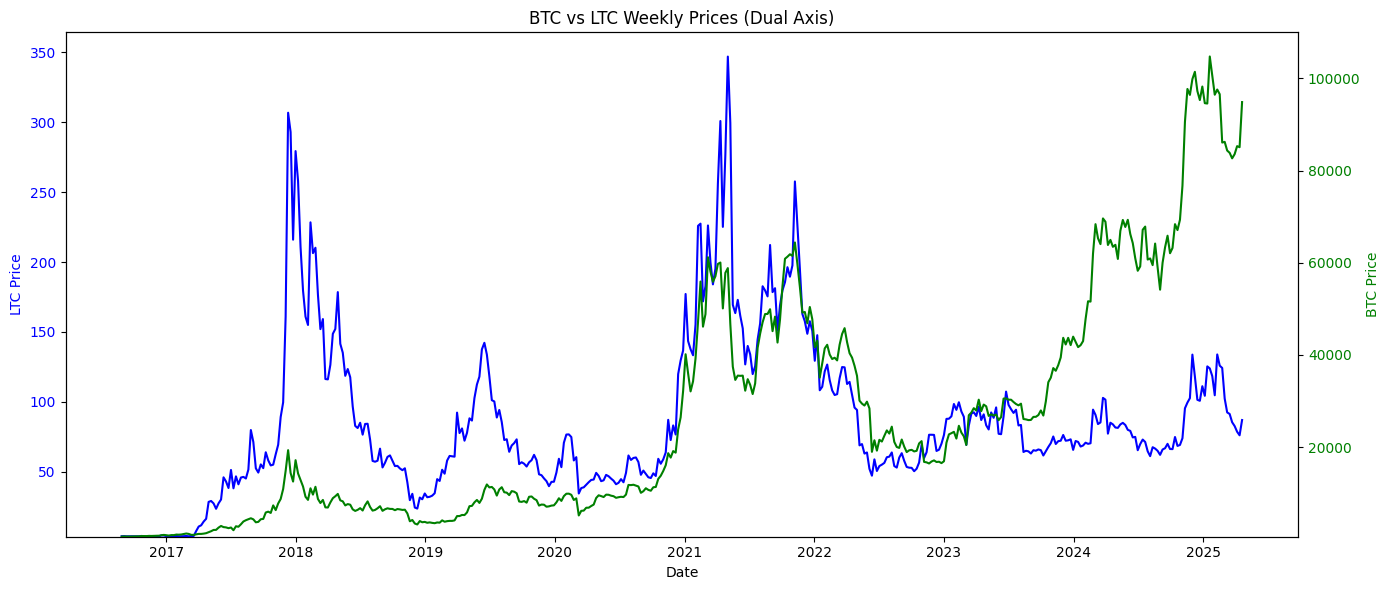

In [14]:
#plotting btc and ltc weekly 

#weekly = weekly.sort_values('Date')

weekly = weekly.sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(weekly['Date'], weekly['Price_ltc'], label='LTC', color='blue', linewidth=1.5)
ax1.set_ylabel('LTC Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(weekly['Date'], weekly['Price_btc'], label='BTC', color='green', linewidth=1.5)
ax2.set_ylabel('BTC Price', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.set_ylim(weekly['Price_ltc'].min() * 0.95, weekly['Price_ltc'].max() * 1.05)
ax2.set_ylim(weekly['Price_btc'].min() * 0.95, weekly['Price_btc'].max() * 1.05)

ax1.set_xlabel('Date')
ax1.set_title('BTC vs LTC Weekly Prices (Dual Axis)')
fig.tight_layout()

plt.show()

In [15]:


X = weekly['Price_Return_btc']
y = weekly['Price_Return_ltc']

valid_idx = X.notna() & y.notna()
X = X[valid_idx]
y = y[valid_idx]

X = sm.add_constant(X)

# regression
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Price_Return_ltc   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     411.3
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           2.14e-65
Time:                        18:06:33   Log-Likelihood:                 355.16
No. Observations:                 451   AIC:                            -706.3
Df Residuals:                     449   BIC:                            -698.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0004      0.005  

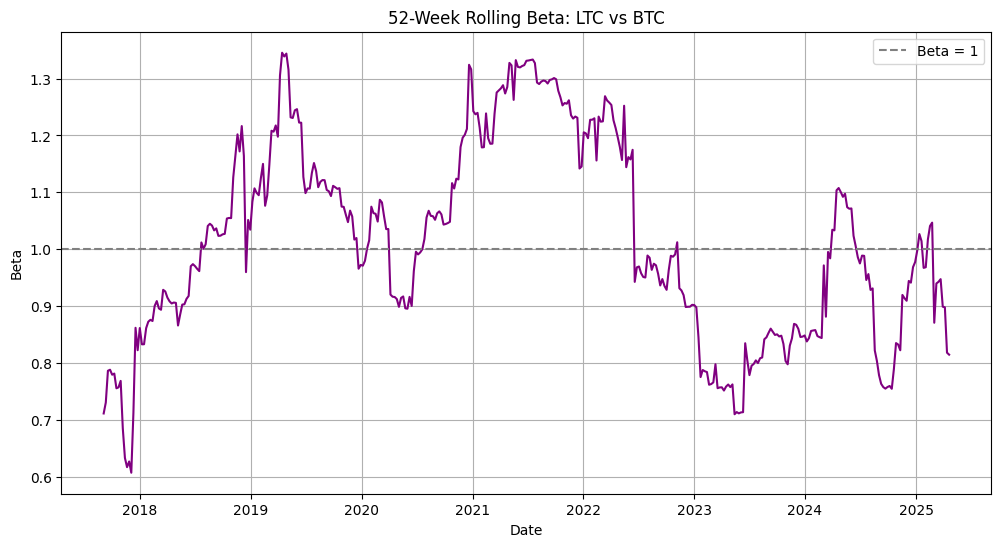

In [16]:
window = 52

rolling_betas = []

for i in range(window, len(weekly)):
    X = weekly['Price_Return_btc'].iloc[i-window:i]
    y = weekly['Price_Return_ltc'].iloc[i-window:i]
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params['Price_Return_btc']
    rolling_betas.append(beta)

beta_dates = weekly['Date'].iloc[window:]

plt.figure(figsize=(12,6))
plt.plot(beta_dates, rolling_betas, color='purple')
plt.axhline(1.0, linestyle='--', color='gray', label='Beta = 1')
plt.title('52-Week Rolling Beta: LTC vs BTC')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)
plt.legend()
plt.show()

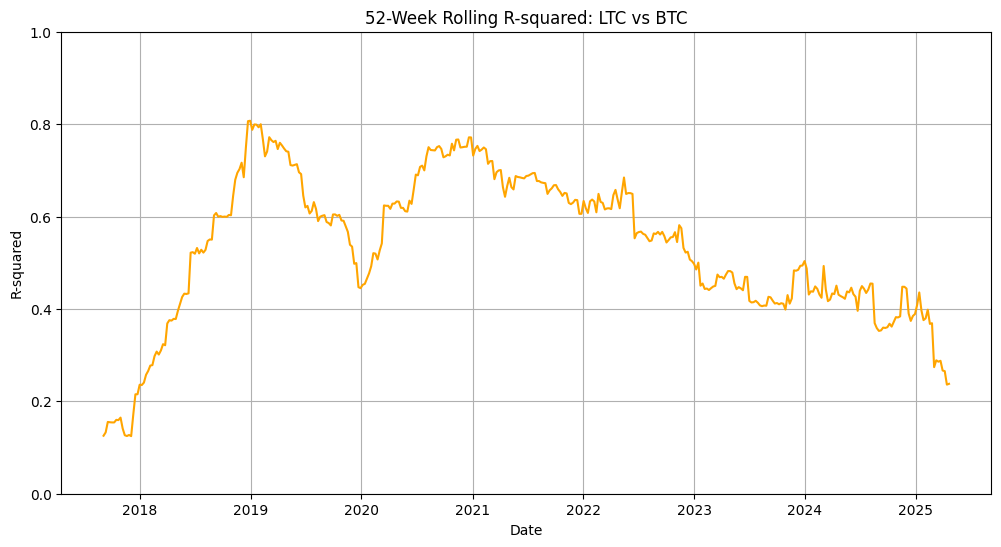

In [17]:
#plotting rsquares

rolling_r2 = []

for i in range(window, len(weekly)):
    X = weekly['Price_Return_btc'].iloc[i-window:i]
    y = weekly['Price_Return_ltc'].iloc[i-window:i]
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    r_squared = model.rsquared
    rolling_r2.append(r_squared)

plt.figure(figsize=(12,6))
plt.plot(beta_dates, rolling_r2, color='orange')
plt.title('52-Week Rolling R-squared: LTC vs BTC')
plt.xlabel('Date')
plt.ylabel('R-squared')
plt.grid(True)
plt.ylim(0, 1)  
plt.show()

In [18]:
monthly = load_and_clean_monthly('litecoin-silver-trend.csv')
monthly.head()

/var/folders/7d/vy32n4kd32bfm2nzwh2qshph0000gn/T/ipykernel_75150/3470014767.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Price,Open,High,Low,Volume,Google Trend,Price_Return
0,2016-09-01,3.81,3.74,6.72,3.26,122610.0,0,NaN
1,2016-10-01,3.98,3.81,4.25,3.70,110110.0,0,0.044619
2,2016-11-01,3.84,3.98,4.50,3.51,149800.0,0,-0.035176
3,2016-12-01,4.36,3.84,5.14,3.32,153670.0,0,0.135417
4,2017-01-01,4.07,4.36,5.99,3.65,397320.0,0,-0.066514


In [19]:
monthly.tail()

,Date,Price,Open,High,Low,Volume,Google Trend,Price_Return
99,2024-12-01,103.26,102.68,146.49,86.95,57520000.0,17,0.005845
100,2025-01-01,128.08,103.29,140.79,93.29,44290000.0,14,0.240364
101,2025-02-01,128.04,128.06,139.88,82.39,67600000.0,17,-0.000312
102,2025-03-01,82.96,127.78,130.63,80.87,44570000.0,13,-0.352077
103,2025-04-01,85.65,82.95,88.49,63.51,25330000.0,17,0.032425


In [20]:
monthly_combined = load_and_clean_monthly_combined('btc-ltc-googletrend-monthly.csv')
monthly_combined.head()

/var/folders/7d/vy32n4kd32bfm2nzwh2qshph0000gn/T/ipykernel_75150/3470014767.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Price LTC,Open LTC,High LTC,Low LTC,Volume LTC,Google Trend,Price BTC,Open BTC,High BTC,Low BTC,Volume BTC,Price_Return_LTC,Price_Return_BTC
0,2016-09-01,3.81,3.74,6.72,3.26,122610.0,0,608.1,573.9,705.0,569.3,748550.0,NaN,NaN
1,2016-10-01,3.98,3.81,4.25,3.70,110110.0,0,698.7,608.1,720.2,606.5,905660.0,0.044619,0.148989
2,2016-11-01,3.84,3.98,4.50,3.51,149800.0,0,742.5,698.7,755.3,670.4,1230000.0,-0.035176,0.062688
3,2016-12-01,4.36,3.84,5.14,3.32,153670.0,0,963.4,742.5,982.6,741.1,1270000.0,0.135417,0.297508
4,2017-01-01,4.07,4.36,5.99,3.65,397320.0,0,965.5,963.4,1150.6,739.5,2210000.0,-0.066514,0.002180


In [21]:
monthly_combined.tail()

,Date,Price LTC,Open LTC,High LTC,Low LTC,Volume LTC,Google Trend,Price BTC,Open BTC,High BTC,Low BTC,Volume BTC,Price_Return_LTC,Price_Return_BTC
99,2024-12-01,103.26,102.68,146.49,86.95,57520000.0,17,93557.2,96404.7,108244.9,91522.3,4410000.0,0.005845,-0.029547
100,2025-01-01,128.08,103.29,140.79,93.29,44290000.0,14,94536.1,94600.0,95928.1,89423.1,55300.0,0.240364,0.010463
101,2025-02-01,128.04,128.06,139.88,82.39,67600000.0,17,84381.2,102421.3,102770.8,78329.8,2400000.0,-0.000312,-0.107418
102,2025-03-01,82.96,127.78,130.63,80.87,44570000.0,13,82548.8,84353.4,94986.5,76677.1,2370000.0,-0.352077,-0.021716
103,2025-04-01,85.65,82.95,88.49,63.51,25330000.0,17,93853.9,82548.6,95718.6,74524.2,2100000.0,0.032425,0.136951


In [23]:
# Removing early observations where googletrend was not recording.
monthly_combined_filtered = monthly_combined[monthly_combined['Date'] > pd.to_datetime('2017-04-01')].copy() 

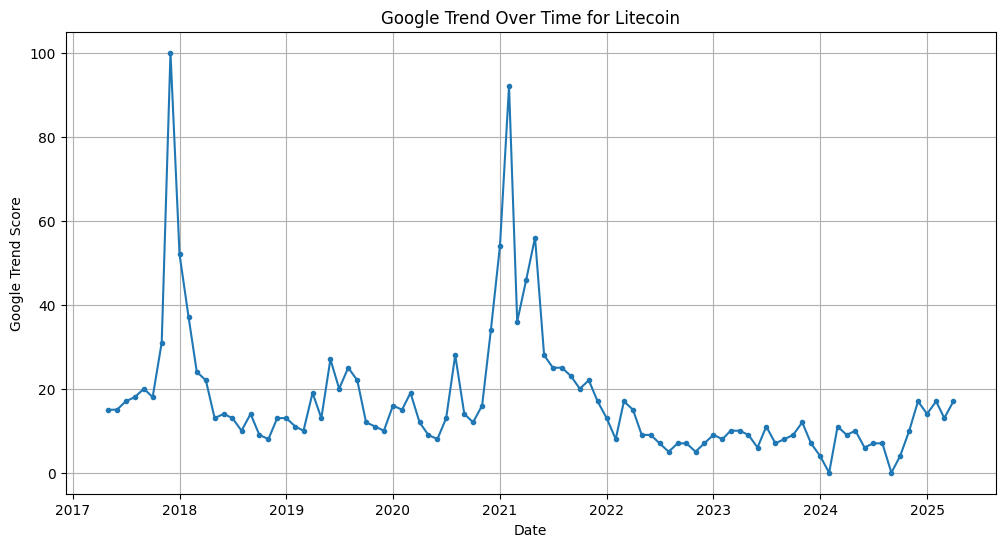

In [24]:
# Plot Google Trend over time
plt.figure(figsize=(12,6))
plt.plot(monthly_combined_filtered['Date'], monthly_combined_filtered['Google Trend'], marker='.', linestyle='-')
plt.title('Google Trend Over Time for Litecoin')
plt.xlabel('Date')
plt.ylabel('Google Trend Score')
plt.grid(True)
plt.show()

In [25]:
Y = monthly_combined['Price_Return_LTC']
X = monthly_combined[['Price_Return_BTC', 'Google Trend']]

combined = pd.concat([Y, X], axis=1).dropna()

Y = combined['Price_Return_LTC']
X = combined[['Price_Return_BTC', 'Google Trend']]

X = sm.add_constant(X)

#regression
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Price_Return_LTC   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     44.10
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           1.85e-14
Time:                        18:07:22   Log-Likelihood:                 1.3273
No. Observations:                 103   AIC:                             3.345
Df Residuals:                     100   BIC:                             11.25
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0543      0.035  

In [26]:
Y = monthly_combined_filtered['Price_Return_LTC']
X = monthly_combined_filtered[['Price_Return_BTC', 'Google Trend']]

combined = pd.concat([Y, X], axis=1).dropna()

Y = combined['Price_Return_LTC']
X = combined[['Price_Return_BTC', 'Google Trend']]

X = sm.add_constant(X)

#regression
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Price_Return_LTC   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     69.37
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           3.64e-19
Time:                        18:07:22   Log-Likelihood:                 21.368
No. Observations:                  96   AIC:                            -36.74
Df Residuals:                      93   BIC:                            -29.04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0926      0.030  

In [27]:
# PLAYPEN
monthly_combined[monthly_combined['Google Trend'] == 0]

,Date,Price LTC,Open LTC,High LTC,Low LTC,Volume LTC,Google Trend,Price BTC,Open BTC,High BTC,Low BTC,Volume BTC,Price_Return_LTC,Price_Return_BTC
0,2016-09-01,3.81,3.74,6.72,3.26,122610.0,0,608.1,573.9,705.0,569.3,748550.0,NaN,NaN
1,2016-10-01,3.98,3.81,4.25,3.70,110110.0,0,698.7,608.1,720.2,606.5,905660.0,0.044619,0.148989
2,2016-11-01,3.84,3.98,4.50,3.51,149800.0,0,742.5,698.7,755.3,670.4,1230000.0,-0.035176,0.062688
3,2016-12-01,4.36,3.84,5.14,3.32,153670.0,0,963.4,742.5,982.6,741.1,1270000.0,0.135417,0.297508
4,2017-01-01,4.07,4.36,5.99,3.65,397320.0,0,965.5,963.4,1150.6,739.5,2210000.0,-0.066514,0.002180
5,2017-02-01,3.85,4.07,4.15,3.62,672510.0,0,1189.3,965.5,1211.7,924.7,1310000.0,-0.054054,0.231797
6,2017-03-01,7.25,3.85,9.90,3.69,4990000.0,0,1079.1,1189.3,1330.4,890.4,2680000.0,0.883117,-0.092660
7,2017-04-01,16.20,7.25,16.74,6.65,34480000.0,0,1351.9,1079.1,1358.9,841.5,1560000.0,1.234483,0.252803
89,2024-02-01,79.87,66.76,84.90,65.74,25710000.0,0,61169.3,42580.1,63915.3,41890.5,1740000.0,0.196375,0.436557
96,2024-09-01,66.88,64.97,71.49,59.67,14180000.0,0,63339.2,58975.7,66440.7,52644.6,2340000.0,0.029398,0.073935
